In [13]:
import numpy as np
from sklearn.cluster import KMeans
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from keras import backend as K
from keras.engine.topology import Layer
from keras.initializers import RandomUniform, Initializer, Constant
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D,GRU, Flatten, SimpleRNN

In [28]:
class InitCentersKMeans(Initializer):
    def __init__(self, X, max_iter=100):
        self.X = X
        self.max_iter = max_iter

    def __call__(self, shape, dtype=None):
        assert shape[1] == self.X.shape[1]

        n_centers = shape[0]
        km = KMeans(n_clusters=n_centers, max_iter=self.max_iter, verbose=0)
        km.fit(self.X)
        return km.cluster_centers_

class RBFLayer(Layer):
    def __init__(self, output_dim, initializer, betas=1.0, **kwargs):
        self.output_dim = output_dim
        self.init_betas = betas
        self.initializer = initializer
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=Constant(
                                         value=self.init_betas),
                                     trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, x):
        C = K.expand_dims(self.centers)
        H = K.transpose(C-K.transpose(x))
        return K.exp(-self.betas * K.sum(H**2, axis=1))
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        config = {
            'output_dim': self.output_dim
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [3]:
signal=lambda t: (1.5*t+0.9)*np.sin(t+1.1)
INTERVAL_START=-5
INTERVAL_END=5
N_PREV_TIME_VALUES=7

In [4]:
def get_signal_values_timed(delta_t, k):
    values=[]
    time_points=[]
    steps=int((INTERVAL_END-INTERVAL_START)/delta_t)
    for t in np.linspace(INTERVAL_START, INTERVAL_END, steps):
        values.append(signal(t))
        time_points.append(t)
    values=np.array([0]*(k-1)+values+[0]*k)
    dataset=timeseries_dataset_from_array(values[:-k], values[k:], sequence_length=k)
    X,y=None, None
    for batch in dataset:
        if X is None or y is None:
            X,y=batch[0].numpy(), batch[1].numpy()
        else:
            X=np.concatenate((X, batch[0].numpy()))
            y=np.concatenate((y, batch[1].numpy()))
    return X, y, time_points

In [5]:
def create_fully_connected_model(n_neurons):
    network = Sequential()
    network.add(Dense(n_neurons, activation='relu', input_shape=(N_PREV_TIME_VALUES,)))
    network.add(Dense(1, activation='linear'))
    network.compile(optimizer='adam',
                    loss='mse')
    return network

In [6]:
def plot_history(histories):
    for (k, history) in histories:
        plt.figure(figsize=(10, 6), dpi= 100, facecolor='w', edgecolor='k')
        plt.title(f'Evaluation of model N neurons={k}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.plot(history.history['loss'], label='Train')
        plt.plot(history.history['val_loss'], label='Validation')
        plt.legend()
        plt.show()

In [7]:
def plot_predictions(predictions, model_name='Model'):
    fig=plt.figure(figsize=(10, 20), dpi= 100, facecolor='w', edgecolor='k')
    for i,(k, time_points, y_predicted, y_true) in enumerate(predictions):
        ax = fig.add_subplot(len(predictions), 1, 1 + i)
        ax.set_title(f"N neurons={k}")
        ax.plot(time_points, y_predicted.flatten(), label="Predicted")
        ax.plot(time_points, y_true, label="Actual")
        ax.legend()
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.show()

In [8]:
def train_validation_split(X, y, val_size):
    val_size=int(X.shape[0]*val_size)
    tscv=TimeSeriesSplit(n_splits=2, test_size=val_size)
    train_index, val_index = list(tscv.split(X))[-1]
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    return X_train, y_train, X_val, y_val

In [9]:
def evaluate_model(create_model, get_signal_values_timed, n_neurons_list):
    histories=[]
    predictions=[]
    for n_neurons in n_neurons_list:
        X,y, time_points=get_signal_values_timed(0.05, N_PREV_TIME_VALUES) 
        model=create_model(n_neurons)
        callbacks=[
            EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True)
        ]
        X_train, y_train, X_val, y_val=train_validation_split(X, y, 0.1)
        model.fit(X,y,validation_data=(X_val, y_val),epochs=1000, verbose=0, callbacks=callbacks)
        histories.append((n_neurons, model.history))
        y_predicted=model.predict(X)
        predictions.append((n_neurons, time_points, y_predicted, y))
    plot_predictions(predictions)
    plot_history(histories)

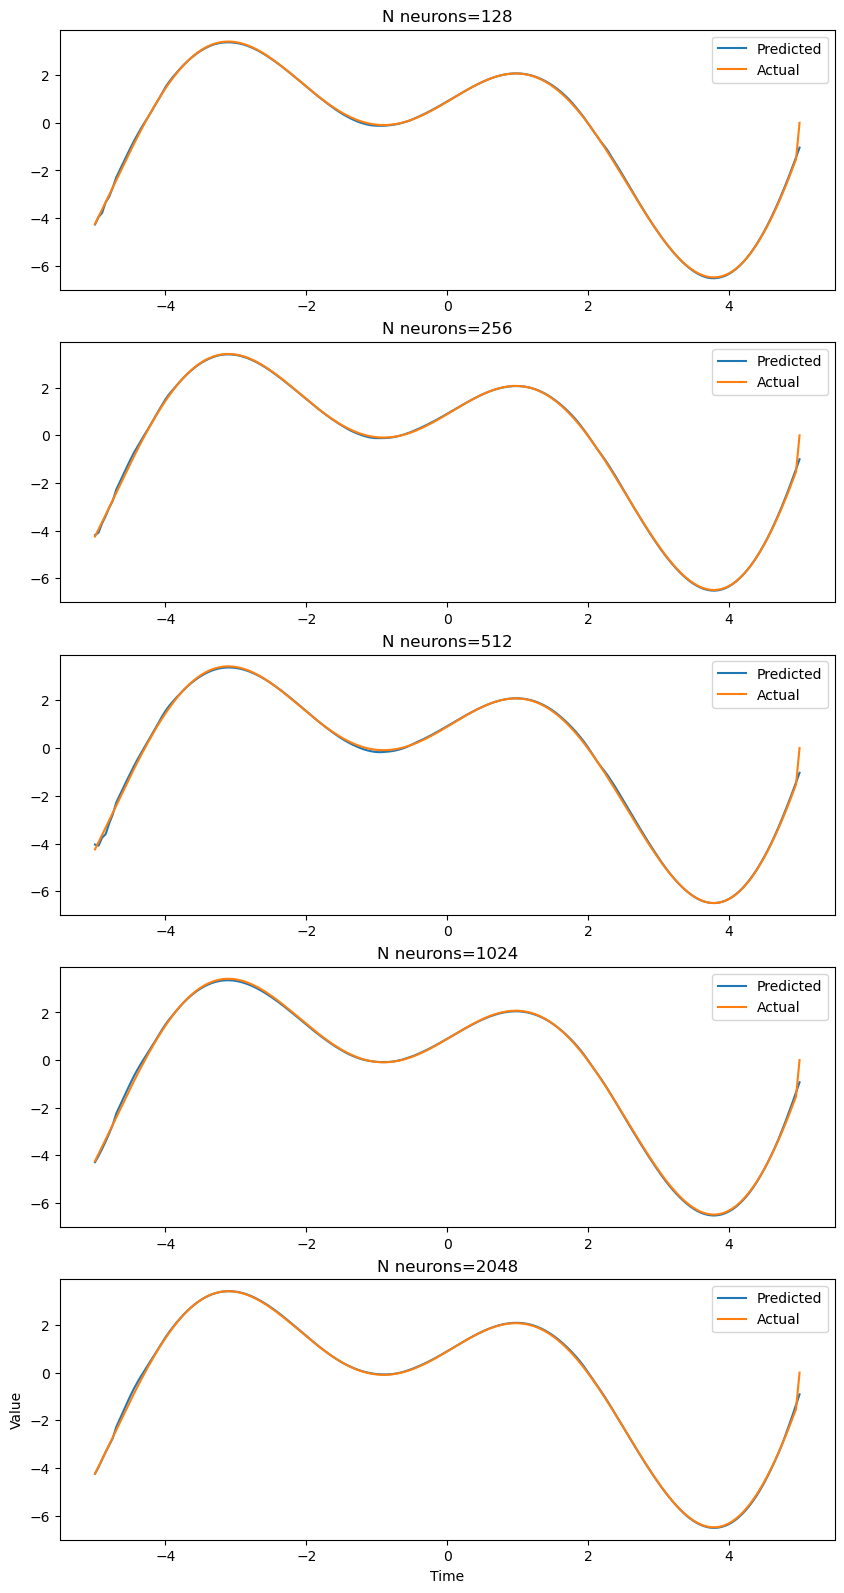

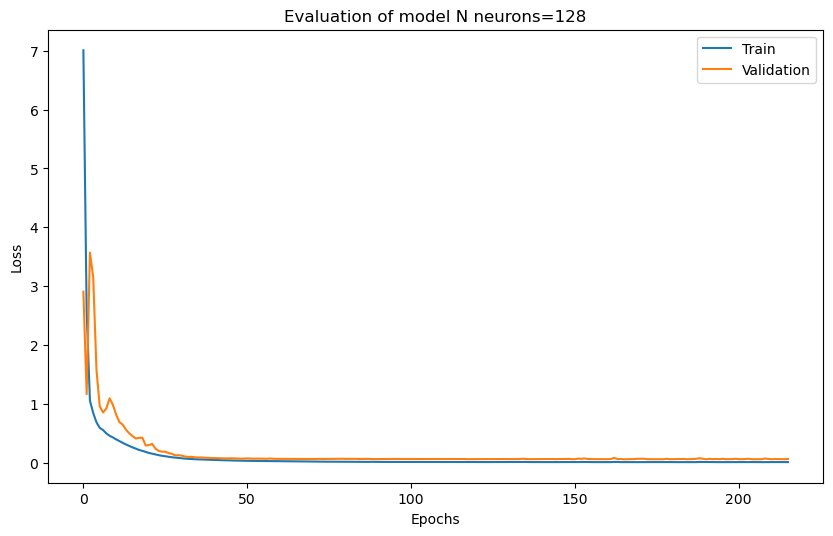

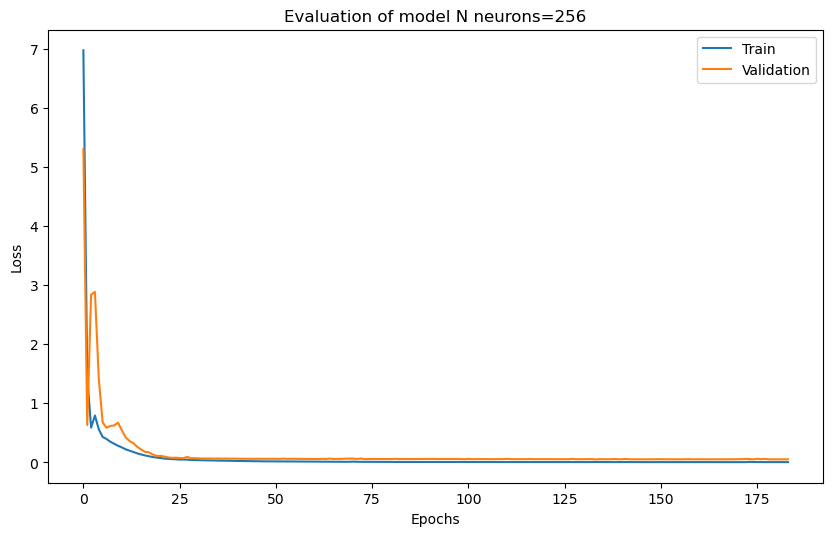

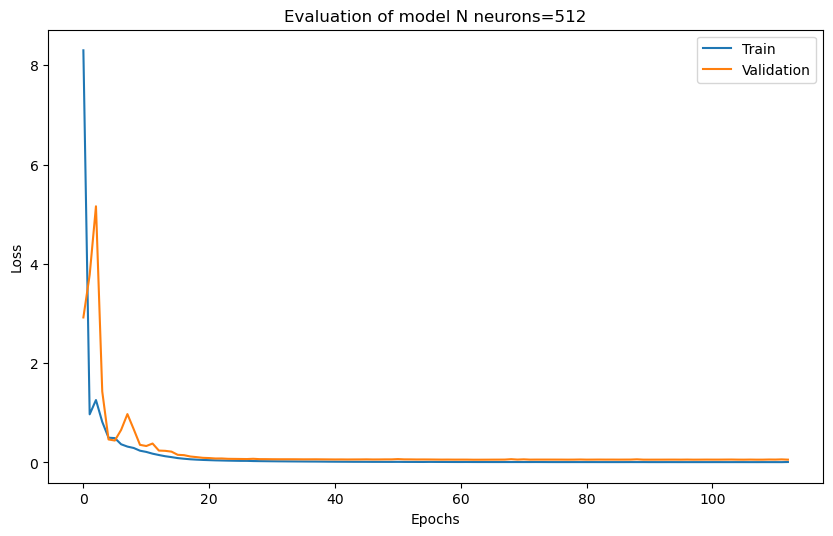

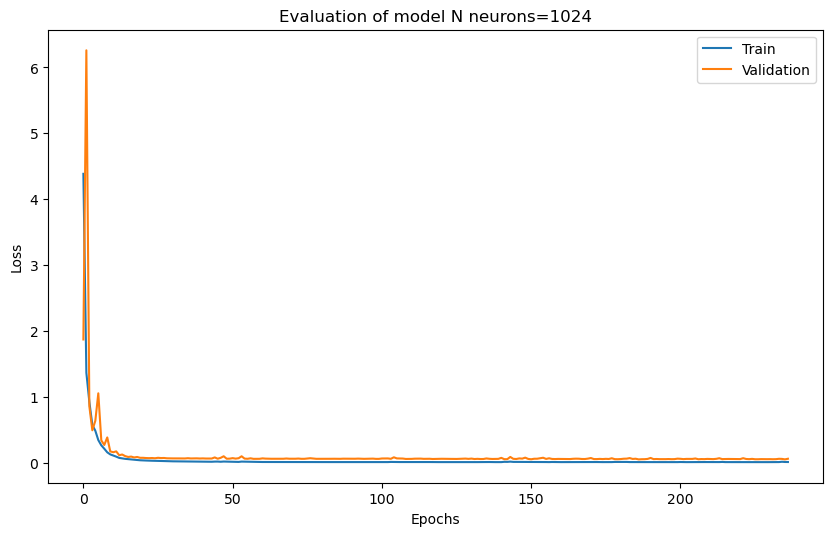

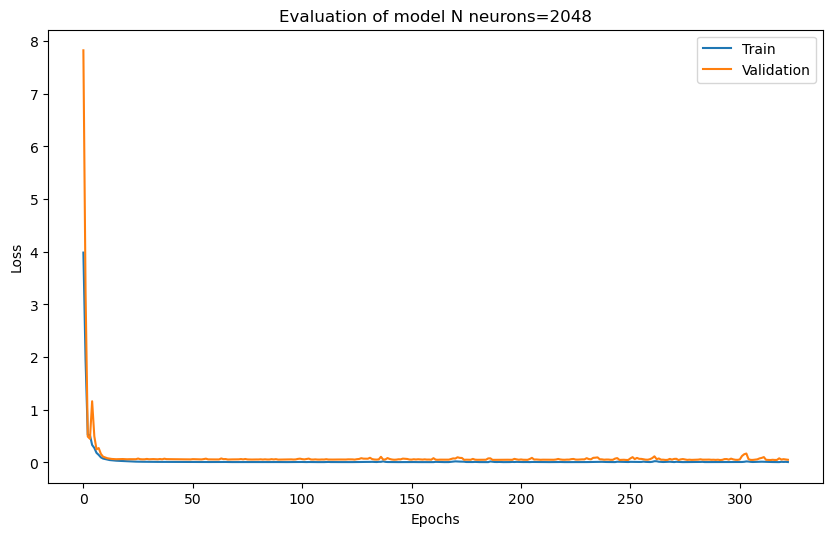

In [10]:
evaluate_model(create_fully_connected_model, get_signal_values_timed, [128, 256, 512, 1024, 2048])

In [24]:
def create_rbf_model(n_neurons, X_train):
    network = Sequential()
    network.add(RBFLayer(n_neurons,betas=2.0,input_shape=(N_PREV_TIME_VALUES,), initializer=InitCentersKMeans(X_train)))
    network.add(Dense(1, activation='linear'))
    network.compile(optimizer='adam',
                    loss='mse')
    return network

In [25]:
def evaluate_model(create_model, get_signal_values_timed, n_neurons_list):
    histories=[]
    predictions=[]
    for n_neurons in n_neurons_list:
        X,y, time_points=get_signal_values_timed(0.05, N_PREV_TIME_VALUES) 
        model=create_model(n_neurons, X)
        callbacks=[
            EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True)
        ]
        X_train, y_train, X_val, y_val=train_validation_split(X, y, 0.1)
        model.fit(X,y,validation_data=(X_val, y_val),epochs=1000, verbose=0, callbacks=callbacks)
        histories.append((n_neurons, model.history))
        y_predicted=model.predict(X)
        predictions.append((n_neurons, time_points, y_predicted, y))
    plot_predictions(predictions)
    plot_history(histories)

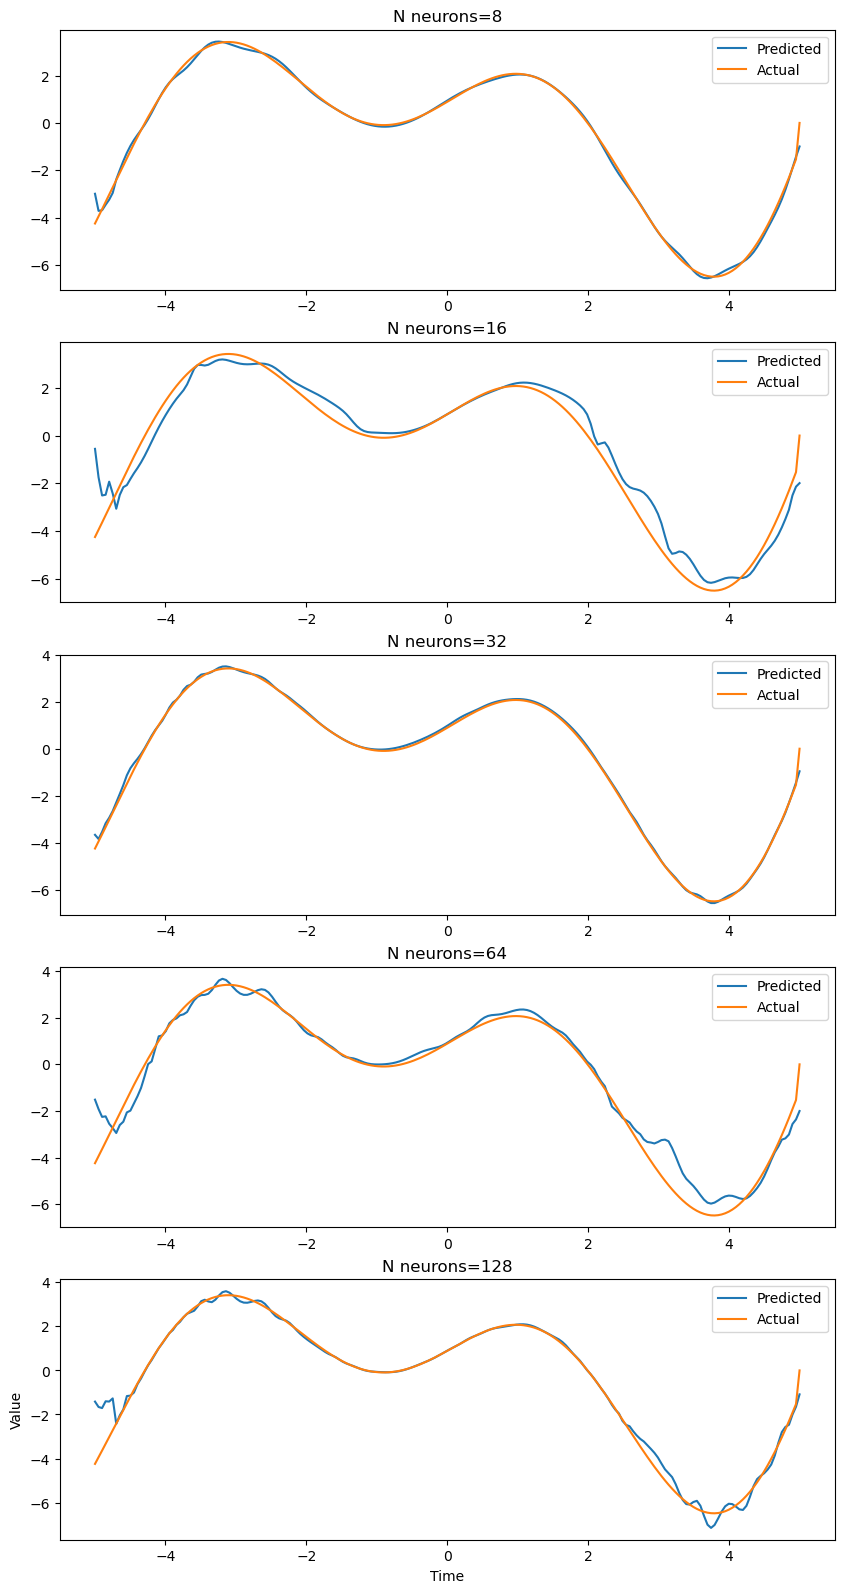

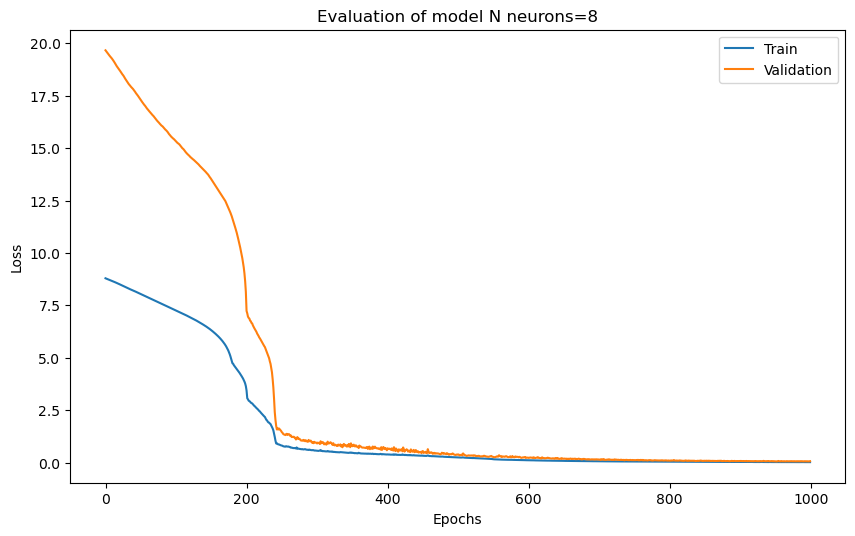

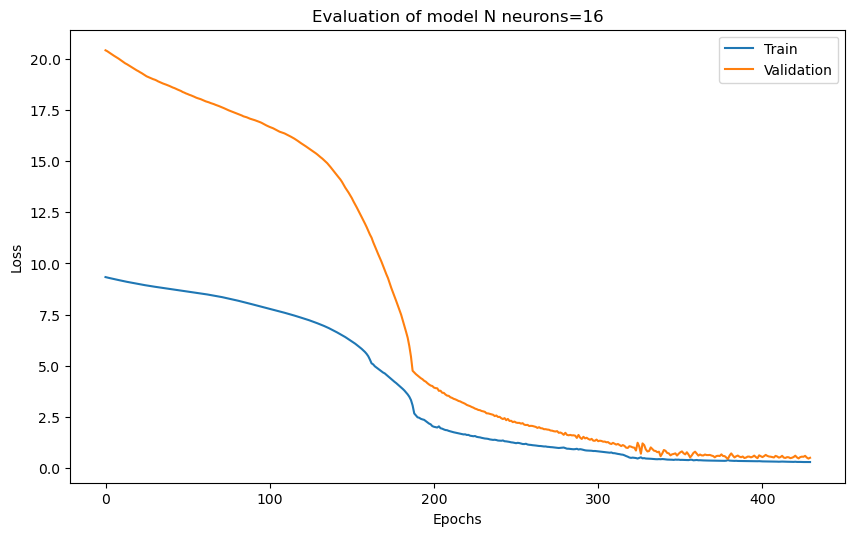

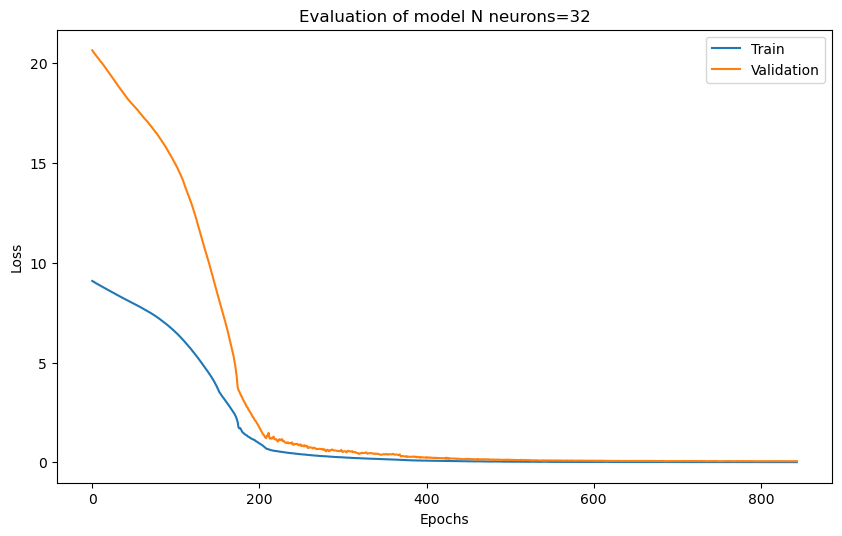

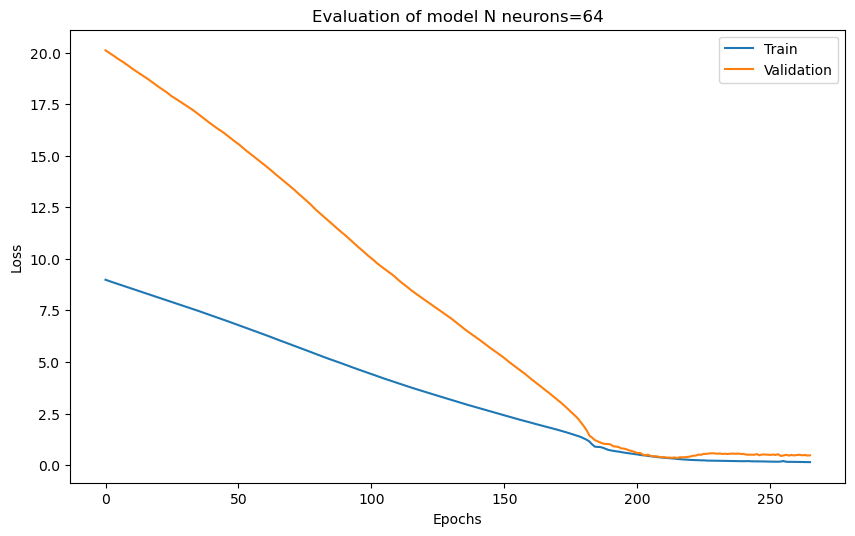

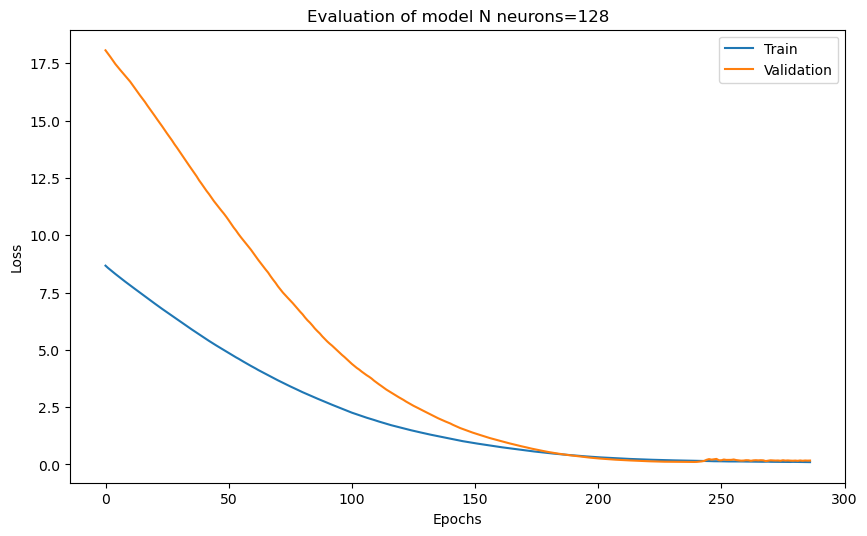

In [29]:
evaluate_model(create_rbf_model, get_signal_values_timed, [8, 16, 32, 64, 128])